## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [1]:
!pip install --upgrade catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [2]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown


# import gdown
# # train
# url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

# output = 'train.csv'
# gdown.download(url, output, quiet=True)

# # test
# url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

# output = 'test.csv'
# gdown.download(url, output, quiet=True)

# # user features
# url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
# output = 'users.csv'
# gdown.download(url, output, quiet=True, fuzzy=True)

# # item features
# url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
# output = 'items.csv'
# gdown.download(url, output, quiet=True)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-

but Gdown can't. Please check connections and permissions.

Метрики

In [2]:
import pandas as pd
import numpy as np
from typing import List, Optional, Union

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0
    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])
    if ideal_dcg == 0.0:
        return 0.0
    ndcg_ = rank_dcg / ideal_dcg
    return ndcg_


def dcg(scores):
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items, predicted):
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt

def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    metric_values = []
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ndcg_metric(gt_items, predictions)
        rr = recall_metric(gt_items, predictions)

        metric_values.append((ap, rr))
    return {'ndcg': np.mean([x[0] for x in metric_values]),
            'recall': np.mean([x[1] for x in metric_values]),
           }

def evaluate_recommender_mf(test_matrix, recommendations):
    metric_values = []
    for user in range(recommendations.shape[0]):
      gt_items = np.where(test_matrix[user] != 0)[0]
      if len(gt_items) == 0:
        continue
      metric_values.append((ndcg_metric(gt_items, recommendations[user]), recall_metric(gt_items, recommendations[user])))
    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

In [4]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [5]:
test_df = pd.read_csv('test.csv')
test_df['last_watch_dt'] = (pd.to_datetime(test_df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
test_df['last_watch_dt'] = test_df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))


In [6]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

**Решение**

**В валидационную выборку соберем последние 30 дней**

In [7]:
import numpy as np
train_df = df.loc[(df.last_watch_dt <= df.last_watch_dt.max() - 30)].copy()
val_df = df.loc[(df.last_watch_dt > df.last_watch_dt.max() - 30)].copy()

train_users = train_df.user_id.unique()
val_users = val_df.user_id.unique()
all_included = np.intersect1d(train_users, val_users)



In [8]:
# ограничим количество пользователей
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)
train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
val_df = val_df.loc[val_df.user_id.isin(all_included)].copy()

# рассматриваем только те айтемы, что были в трейне
train_items = train_df.item_id.unique()
val_df = val_df[val_df['item_id'].isin(train_items)].copy()

In [9]:
def create_frame(train_df, test_df):
  train_grouped = train_df.groupby('user_id').apply(
      lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                  x.last_watch_dt), key=lambda x: x[1])]
  ).reset_index()
  train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)
  if test_df is None:
    return train_grouped
  test_grouped = test_df.groupby('user_id').apply(
      lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                          x.last_watch_dt), key=lambda x: x[1])]
  ).reset_index()
  test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)
  train_grouped.head()
  return train_grouped, test_grouped

In [10]:
train_grouped, test_grouped = create_frame(train_df, val_df)
joined = train_grouped.merge(test_grouped)
joined.head()

<ipython-input-9-5c7d458a66d3>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-9-5c7d458a66d3>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions,test_interactions
0,3,"[(2657, 82)]","[(3734, 131), (9728, 132), (9550, 132), (10440..."
1,106,"[(9335, 28), (11494, 35), (312, 35), (12965, 5...","[(9164, 127)]"
2,192,"[(15297, 103)]","[(10440, 125), (9996, 131)]"
3,370,"[(10440, 105), (16107, 105), (142, 107), (1386...","[(9561, 123), (13167, 123), (6455, 124), (2265..."
4,498,"[(4495, 117)]","[(4740, 124), (11312, 124)]"


In [11]:
def df_encode(df, mode='train', item2id=None, user2id=None, id2item=None, id2user=None):
    if mode == 'train':
      item2id = {k:v for v, k in enumerate(df.item_id.unique())}
      user2id = {k:v for v, k in enumerate(df.user_id.unique())}

      id2item = {k:v for v, k in item2id.items()}
      id2user = {k:v for v, k in user2id.items()}

    df = df.copy()
    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df, user2id, item2id, id2user, id2item

In [12]:
filtered_train, user2id, item2id, id2user, id2item = df_encode(train_df)
filtered_val, _, _, _, _ = df_encode(val_df, mode='test', item2id=item2id, user2id=user2id, id2item=id2item, id2user=id2user)

In [13]:
from scipy import sparse as sps

def create_matrix(filtered_df, user2id, item2id):
  return sps.coo_matrix(
    (np.ones(filtered_df.shape[0]), (filtered_df['user_id'], filtered_df['item_id'])),
    shape=(len(user2id), len(item2id)),)


matrix = create_matrix(filtered_train, user2id, item2id)
matrix_test = create_matrix(filtered_val, user2id, item2id)


Первая модель -- **EASE**

In [14]:
from scipy import sparse as sps

class EASE:

  def __init__(self, user2id, item2id, id2user, id2item):
    self.item2id = item2id
    self.id2item = id2item
    self.user2id = user2id
    self.id2user = id2user

  def fit_ease(self, X, reg_weight=100):
    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)
    self.w = B
    return B

  def get_preds_all(self, x, item2id, id2item, topn=100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topn]
    return decoded

  def get_score(self, data_df, user, item):

    if not (user in self.user2id):
      return 0.
    if not (item in self.item2id):
      return 0.
    # создаем вектор интеракций пользователя
    vector = self.get_vector_interactions_of_user(data_df, user)
    score = np.array(vector.dot(self.w.T[self.item2id[item]].T))[0][0]
    return 1 / (1 + np.exp(-score))

  def get_vector_interactions_of_user(self, data_df, user):
    vector = np.zeros(len(self.item2id)).astype(np.float32)
    if user in data_df['user_id'].values:
      covered_items = data_df[data_df['user_id'] == user].item_id.values
      covered_items = np.vectorize(self.item2id.get)(covered_items)
      vector[covered_items] = 1.
    return vector

  def get_score_batch(self, data_df, users, items):
    scores = []
    users_vector = {}
    for user, item in zip(users, items):
      if user not in self.user2id or item not in self.item2id:
        scores.append(0.)
        continue
      if user not in users_vector:
        vector = self.get_vector_interactions_of_user(data_df, user)
        users_vector[user] = vector
      else:
        vector = users_vector[user]
      item_id = self.item2id[item]
      score = np.array(vector.dot(self.w.T[item_id].T))[0][0]
      score = 1 / (1 + np.exp(-score))
      scores.append(score)
    return scores

In [138]:
model_ease = EASE(user2id, item2id, id2user, id2item)
w = model_ease.fit_ease(matrix)

In [ ]:
joined

,user_id,train_interactions,test_interactions
0,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(4042, 131), (4457, 131), (4151, 133)]"
1,192,"[(15297, 103)]","[(10440, 125), (9996, 131)]"
2,322,"[(14814, 94), (14242, 94), (12820, 94), (9728,...","[(4495, 134), (587, 138), (13720, 138), (4442,..."
3,424,"[(14470, 118)]","[(15297, 131), (1916, 131)]"
4,618,"[(10440, 110)]","[(8636, 130), (13865, 136), (2616, 136), (288,..."
...,...,...,...
9671,1097101,"[(13865, 86), (9728, 111), (4976, 120)]","[(10440, 131), (9281, 148), (5109, 148), (1188..."
9672,1097276,"[(7557, 46), (6809, 57), (10411, 58), (13791, ...","[(11237, 130), (10440, 130), (3182, 139), (373..."
9673,1097287,"[(15297, 84), (10440, 97), (11245, 122)]","[(496, 126)]"
9674,1097506,"[(5453, 5), (8626, 60), (1819, 79), (4880, 79)...","[(10198, 138)]"


In [139]:
joined['ease_preds'] = joined.train_interactions.apply(lambda x: model_ease.get_preds_all(x, item2id, id2item))
evaluate_recommender(joined, model_preds='ease_preds')

{'ndcg': 0.5342935597866979, 'recall': 0.387099455842117}

**Модель №2**-- **Матричная факторизация через SVD**

In [16]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import coo_array
from typing import Union

class MatrixSVD:
    def __init__(self, user2id, item2id, id2user, id2item):
      self.item2id = item2id
      self.id2item = id2item
      self.user2id = user2id
      self.id2user = id2user
      self.U = None
      self.S = None
      self.V = None

    def make_svd(self, interactions: coo_array, n_singular_values: int = 10):
      interactions = coo_array(interactions)
      self.U, self.S, self.V = svds(interactions, k=n_singular_values)
      self.U = self.U.astype(np.float32)
      self.S = self.S.astype(np.float32)
      self.V = self.V.astype(np.float32)

    def predict_for_users(self, user_indices: np.ndarray):
      return (self.U[user_indices] * self.S) @ self.V

    def make_svd_recommendations(self, interactions: Union[np.ndarray, coo_array], n_singular_values: int = 10, top_k: int = 100, batch_size: int = 1024):
      interactions = coo_array(interactions)
      self.make_svd(interactions, n_singular_values)
      n_users = interactions.shape[0]
      n_items = interactions.shape[1]
      recommendations = np.empty((n_users, top_k), dtype=np.int32)
      # CSR -- чтобы быстро получать совершенные интеракции пользователя
      interactions_csr = interactions.tocsr()
      for i in range(0, n_users, batch_size):
          user_batch = np.arange(i, min(i + batch_size, n_users))
          ratings_batch = self.predict_for_users(user_batch)

          for idx, user in enumerate(user_batch):
              # получаем список айтемов, с которыми уже были взаимодействия
              start_ptr = interactions_csr.indptr[user]
              end_ptr = interactions_csr.indptr[user + 1]
              liked_items = interactions_csr.indices[start_ptr:end_ptr]
              ratings_batch[idx, liked_items] = -np.inf
          # эту часть кода с использованием argpartition помог написать gpt на запрос о том, как можно оптимизировать argsort
          top_k_indices = np.argpartition(ratings_batch, -top_k, axis=1)[:, -top_k:]
          # cортируем топ_k индексов по возрастанию релевантности
          sorted_top_k_indices = np.argsort(ratings_batch[np.arange(ratings_batch.shape[0])[:, None], top_k_indices], axis=1)
          final_indices = top_k_indices[np.arange(top_k_indices.shape[0])[:, None], sorted_top_k_indices]
          recommendations[user_batch] = final_indices.astype(np.int32)
      return recommendations

    def get_score(self, user: int, item: int):
      if (user in self.user2id) and (item in self.item2id):
          user = self.user2id[user]
          item = self.item2id[item]
          return ((self.U[user] * self.S) @ self.V)[item]
      return 0.


In [17]:
model_matrix = MatrixSVD(user2id, item2id, id2user, id2item)
mf_recommendations = model_matrix.make_svd_recommendations(coo_array(matrix), 10, 100)

In [ ]:
evaluate_recommender_mf(matrix_test.toarray(), mf_recommendations)

{'ndcg': 0.45354131112962587, 'recall': 0.30833562443042567}

In [39]:
np.sum(((model_matrix.U[np.array([1, 3])] * model_matrix.S)* model_matrix.V.T[np.array([4, 6])]), axis=1)

array([0.00055175, 0.00983171], dtype=float32)

**Модель №3 -- NCF**

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [171]:
class NCF(nn.Module):

  def __init__(self, train_df, users_encoder, items_encoder, device, hidden_size=32, n_factors=16):
    super().__init__()
    self.train_df = train_df
    self.device = device
    self.users_encoder = users_encoder
    self.items_encoder = items_encoder
    self.n_users = train_df.user_id.nunique()
    self.n_items = train_df.item_id.nunique()
    self.hidden_size = hidden_size
    self.n_factors = n_factors
    self.user_emb = nn.Embedding(self.n_users, self.n_factors)
    self.item_emb = nn.Embedding(self.n_items, self.n_factors)
    self.sigmoid = nn.Sigmoid()
    self.layout = nn.Sequential(
        nn.Linear(self.n_factors * 2, self.hidden_size),
        nn.ReLU(),
        nn.Linear(self.hidden_size, self.hidden_size // 2),
        nn.ReLU(),
        nn.Linear(self.hidden_size // 2, 1),
    )

  def forward(self, user, item):
    x = self.user_emb(user)
    y = self.item_emb(item)
    res = torch.cat([x, y], dim=1)
    res = self.layout(res)
    return self.sigmoid(res).squeeze(-1)

  def transform(self, x):
    return self.items_encoder.transform(x).tolist()

  def get_score(self, user, item):
    if not(user in self.users_encoder.classes_):
      return 0
    if not(item in self.items_encoder.classes_):
      return 0
    user = self.users_encoder.transform([user])[0]
    item = self.items_encoder.transform([item])[0]
    with torch.no_grad():
      return self.forward(torch.Tensor([user]).long().to(self.device), torch.Tensor([item]).long().to(self.device)).item()

  def get_score_batch(self, users, items):
    valid_pairs = [
        (user in self.users_encoder.classes_) and (item in self.items_encoder.classes_)
        for user, item in zip(users, items)
    ]
    encoded_users = [user for user, mask in zip(users, valid_pairs) if mask]
    encoded_items = [item for item, mask in zip(items, valid_pairs) if mask]

    if len(encoded_users) == 0:
      return np.zeros(len(users))
    if len(encoded_items) == 0:
      return np.zeros(len(users))

    encoded_users = self.users_encoder.transform(encoded_users)
    encoded_items = self.items_encoder.transform(encoded_items)
    encoded_users = torch.Tensor(encoded_users).long().to(self.device)
    encoded_items = torch.Tensor(encoded_items).long().to(self.device)

    with torch.no_grad():
      scores =  self.forward(encoded_users, encoded_items).detach().cpu().numpy()
    all_scores = []
    index = 0
    for mask in valid_pairs:
      if mask:
        all_scores.append(scores[index])
        index += 1
      else:
        all_scores.append(0.)
    return np.array(all_scores)


  def make_recommendations(self, users_encoder, items_encoder, train_encoded_users,  train_encoded_items, device, topn=100, batch_size=128):
    self.eval()
    recommendations = []
    all_items = list(range(self.n_items))
    user_interactions = self.train_df.groupby('user_id').agg({'item_id': self.transform})
    with torch.no_grad():
      for i in range(0, self.n_users):
        pred = np.array([])

        true_recomm = user_interactions.loc[users_encoder.inverse_transform([i])].values[0][0]

        for j in range(0, self.n_items, batch_size):
          batch_items = all_items[j:j+batch_size]
          current_batch_size = len(batch_items)
          batch_items = torch.Tensor(batch_items).long().to(device)
          batch_users = torch.Tensor([i] * current_batch_size).long().to(device)
          pred = np.append(pred, self.forward(batch_users, batch_items).detach().cpu().numpy())
        pred[true_recomm] = -np.inf
        pred = np.argsort(pred)[-topn:]
        recommendations.append(pred)
    return recommendations


In [ ]:
from torch.utils.data import Dataset, DataLoader
import random

class NCFDataset(torch.utils.data.Dataset):
  def __init__(self, train_encoded_users, train_encoded_items, num_negatives=1):
    super().__init__()
    self.train_encoded_users = train_encoded_users
    self.train_encoded_items = train_encoded_items
    self.num_negatives = num_negatives
    self.positives = set(zip(self.train_encoded_users.tolist(), self.train_encoded_items.tolist()))
    self.data = self._data()

  def _data(self):
    data = []
    for user, item in self.positives:
      data.append((user, item, 1))
      for j in range(self.num_negatives):
        negatives_items = int(random.choice(self.train_encoded_items))
        while (user, negatives_items) in self.positives:
          negatives_items = int(random.choice(self.train_encoded_items))
        data.append((user, negatives_items, 0))
    return data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return torch.tensor(self.data[idx], dtype=torch.long)

In [ ]:
users_encoder = LabelEncoder().fit(train_df.user_id.values)
items_encoder = LabelEncoder().fit(train_df.item_id.values)

train_encoded_users = torch.Tensor(users_encoder.transform(train_df.user_id.values)).long()
train_encoded_items = torch.Tensor(items_encoder.transform(train_df.item_id.values)).long()


In [ ]:
from torch.utils.data import Dataset, DataLoader

dataset = NCFDataset(train_encoded_users, train_encoded_items)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
model_ncf = NCF(train_df, users_encoder, items_encoder, device=device).to(device)

In [ ]:
def train(model_ncf, dataloader, device):
  optimizer = torch.optim.Adam(model_ncf.parameters(), lr=1e-4)
  loss = nn.BCEWithLogitsLoss()

  model_ncf.train()
  for epoch in range(10):
    for batch in tqdm(dataloader):
      users, items, labels = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
      optimizer.zero_grad()
      pred = model_ncf(users, items)
      cur_loss = loss(pred, labels)
      cur_loss.backward()
      optimizer.step()


In [ ]:
train(model_ncf, dataloader, device)


  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1437 [00:00<?, ?it/s]

In [ ]:
recommendations = model_ncf.make_recommendations(users_encoder, items_encoder, train_encoded_users, train_encoded_items, device=device, batch_size=train_df.item_id.nunique())

In [ ]:
filtered_val = val_df.copy()
filtered_val['user_id'] = filtered_val.user_id.apply(lambda x: users_encoder.transform([x])[0])
filtered_val['item_id'] = filtered_val.item_id.apply(lambda x: items_encoder.transform([x])[0])

In [ ]:
matrix_test = sps.coo_matrix(
    (np.ones(filtered_val.shape[0]), (filtered_val['user_id'], filtered_val['item_id'])),
    shape=(train_df.user_id.nunique(), train_df.item_id.nunique()),
)

In [ ]:
evaluate_recommender_mf(matrix_test.toarray(), np.array(recommendations))

{'ndcg': 0.2093649023366641, 'recall': 0.14336194740680622}

**Анализ кандидатов генераторов.**

---

Будем использовать метрику RBO.
Выберем подможество юзеров размерности 100 и посчитаем RBO между их рекомендациями для каждой модели.

In [ ]:
!pip install rbo

from rbo import rbo

def ranked_based_overlap(recom1, recom2):
  return rbo.RankingSimilarity(recom1, recom2).rbo()

def calculate_rbo(recommendations: Union[np.ndarray, pd.DataFrame], n=100):
  result_rbo = 0
  users = np.random.choice(recommendations.shape[0], size=n, replace=False)
  for i in range(0, len(users), 2):

    if isinstance(recommendations, pd.DataFrame):
      result_rbo += ranked_based_overlap(recommendations.iloc[users[i]], recommendations.iloc[users[i+1]])
    else:
      result_rbo += ranked_based_overlap(recommendations[users[i]], recommendations[users[i+1]])
  return result_rbo / n


In [ ]:
print(f'RBO for Matrix Factorization Model: {calculate_rbo(mf_recommendations)}')
print(f'RBO for NCF Model: {calculate_rbo(np.array(recommendations))}')
print(f'RBO for EASE Model: {calculate_rbo(joined["ease_preds"])}')

RBO for Matrix Factorization Model: 0.0980303346948049
RBO for NCF Model: 0.10491523352768514
RBO for EASE Model: 0.12141806800333674


Модели рекомендуют разные товары, так как метрика RBO достаточно мала


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [ ]:
df_users = pd.read_csv('users.csv')
df_items = pd.read_csv('items.csv')

df_users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


**Реализуем вариант №2** -- Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. (2 балла)

В функции create_features_ есть аргумент from_df, будем его обновлять, добавляя данные с каждого прошедшего дня, а аргумент to_df передавать так, чтобы обновлялся лишь рассматриваемый день.


In [140]:
def create_features_(from_df, to_df, df_users, df_items):
  to_df = to_df.copy()
  from_df = from_df.copy()

  # пользовательские признаки (age, sex)
  to_df = pd.merge(to_df, df_users[['user_id', 'age', 'sex']], on='user_id', how='left')
  from_df = pd.merge(from_df, df_users[['user_id', 'age', 'sex']], on='user_id', how='left')

  # признаки для айтемов (год релиза, режиссер, средний % просмотра этого фильма)
  to_df = pd.merge(to_df, df_items[['item_id', 'release_year', 'directors']], on='item_id', how='left')
  from_df = pd.merge(from_df, df_items[['item_id', 'release_year', 'directors']], on='item_id', how='left')

  # фича: средний % просмотра этого фильма (для айтема)
  item_avg_watched_pct = from_df.groupby('item_id')['watched_pct'].mean().reset_index(name='item_avg_watched_pct')
  to_df = pd.merge(to_df, item_avg_watched_pct, on='item_id', how='left')

  #пропуски
  to_df['age'] = to_df['age'].fillna('Unknown')
  to_df['sex'] = to_df['sex'].fillna('Unknown')
  to_df['release_year'] = to_df['release_year'].fillna(to_df['release_year'].median())
  to_df['directors'] = to_df['directors'].fillna('Unknown')
  to_df['item_avg_watched_pct'] = to_df['item_avg_watched_pct'].fillna(to_df['item_avg_watched_pct'].median())

  # признаки юзер - айтем:
  # 1 -- количество раз, которые юзеры данной возрастной категории видели айтем (чтобы без ликов - берем из from_df)
  age_item_nums = from_df.groupby(['age', 'item_id']).size().reset_index(name='age_item_nums')
  to_df = pd.merge(to_df, age_item_nums, on=['age', 'item_id'], how='left')
  to_df['age_item_nums'] = to_df['age_item_nums'].fillna(0)

  # 2 -- среднее время просмотра у юзеров данного возраста для данного айтема
  age_item_watch_pct =  from_df.groupby(['age', 'item_id'])['watched_pct'].mean().reset_index(name='age_item_watch_pct')
  to_df = pd.merge(to_df, age_item_watch_pct, on=['age', 'item_id'], how='left')
  to_df['age_item_watch_pct'] = to_df['age_item_watch_pct'].fillna(0)

  # 3 -- количество раз, которые юзеры данного пола видели айтем
  sex_item_nums = from_df.groupby(['sex', 'item_id']).size().reset_index(name='sex_item_nums')
  to_df = pd.merge(to_df, sex_item_nums, on=['sex', 'item_id'], how='left')
  to_df['sex_item_nums'] = to_df['sex_item_nums'].fillna(0)

  # 4 -- количество раз, которые юзеры данного пола видели фильм данного режиссера
  sex_directors_nums = from_df.groupby(['sex', 'directors']).size().reset_index(name='sex_directors_nums')
  to_df = pd.merge(to_df, sex_directors_nums, on=['sex', 'directors'], how='left')
  to_df['sex_directors_nums'] = to_df['sex_directors_nums'].fillna(0)

  # 5 -- количество раз, которые  юзер смотрел фильмы определенного года релиза (чтобы понять любит ли юзер новые/старые фильмы)
  user_release_year_nums = from_df.groupby(['user_id', 'release_year']).size().reset_index(name='user_release_year_nums')
  to_df = pd.merge(to_df, user_release_year_nums, on=['user_id', 'release_year'], how='left')
  to_df['user_release_year_nums'] = to_df['user_release_year_nums'].fillna(0)

  # 6 -- среднее время просмотра у конкретного юзера для айтемов определенного года релиза (аналогично пункту 5)
  user_release_year_watch_pct = from_df.groupby(['user_id', 'release_year'])['watched_pct'].mean().reset_index(name='user_release_year_watch_pct')
  to_df = pd.merge(to_df, user_release_year_watch_pct, on=['user_id', 'release_year'], how='left')
  to_df['user_release_year_watch_pct'] = to_df['user_release_year_watch_pct'].fillna(0)
  return to_df


In [141]:
def new_features(from_df, to_df, df_users, df_items):

  days = to_df.last_watch_dt.unique()
  result_df = pd.DataFrame()
  # считаем признаки на каждый день
  for day in days:
    features_on_current_day = create_features_(pd.concat([from_df, to_df[to_df.last_watch_dt < day]]), to_df[to_df.last_watch_dt == day], df_users, df_items)
    result_df = pd.concat([result_df, features_on_current_day])
  return result_df

In [142]:
train_df_with_features = new_features(train_df, val_df, df_users, df_items)
test_df_with_features = new_features(from_df = pd.concat([train_df, val_df], axis=0), to_df=test_df, df_users=df_users, df_items=df_items)


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [143]:
def add_scores(data_df, from_df,  model_ease, model_matrix, model_ncf):
  user_ids = data_df['user_id'].values
  item_ids = data_df['item_id'].values
  data_df['score_ease'] = model_ease.get_score_batch(from_df, user_ids, item_ids)
  data_df['score_ncf'] = model_ncf.get_score_batch(user_ids, item_ids)
  #data_df['score_mf'] = data_df.apply(lambda x: model_matrix.get_score(x['user_id'], x['item_id']), axis=1)
  return data_df

In [144]:
X_train = add_scores(train_df_with_features, train_df_with_features, model_ease, model_matrix, model_ncf)
y_train = X_train['target']
X_train = X_train.drop(columns=['last_watch_dt', 'total_dur', 'watched_pct', 'target'])

In [146]:
X_test = add_scores(test_df_with_features, train_df_with_features, model_ease, model_matrix, model_ncf)
y_test = X_test['target']
X_test = X_test.drop(columns=['last_watch_dt', 'total_dur', 'watched_pct', 'target'])

In [152]:
from catboost import CatBoostClassifier

model_classifier = CatBoostClassifier(iterations=100,
                                         random_seed=42,
                                         eval_metric='AUC',
                                         loss_function='Logloss',
                                         task_type="GPU" if torch.cuda.is_available() else "CPU"
                                         )
categorical_features = ['age', 'sex', 'directors']
model_classifier.fit(X_train, y_train,
                    cat_features=categorical_features,
                    verbose=10)

Learning rate set to 0.216035


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 58.3ms	remaining: 5.78s
10:	total: 123ms	remaining: 997ms
20:	total: 187ms	remaining: 704ms
30:	total: 249ms	remaining: 555ms
40:	total: 328ms	remaining: 472ms
50:	total: 395ms	remaining: 380ms
60:	total: 452ms	remaining: 289ms
70:	total: 508ms	remaining: 207ms
80:	total: 567ms	remaining: 133ms
90:	total: 625ms	remaining: 61.8ms
99:	total: 671ms	remaining: 0us


In [153]:
from sklearn.metrics import roc_auc_score

y_pred_train = model_classifier.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_train)

print(f"Train AUC: {train_auc}")


Train AUC: 0.7423121923610142


По поводу рекомендаций на тесте:

Поскольку в этом задании не просили выдать рекомендации, то холодных пользователей не будем обрабатывать отдельно, будем просто выдавать им некоторые скор -- предсказание модели catboost.

Если бы в этом задании попросили выдать рекомендации, то таким юзерам вместо модели первого уровня, мы бы просто выдали самые популярные айтемы, а уже потом использовали бы бустинг для ранжирования этих айтемов. Но здесь нигде не сказано, что нужно выдать рекомендации. А в следующем задании это не пригодится, поскольку мы обучаемся на всех данных.

In [154]:
X_test['boosting_score'] = model_classifier.predict_proba(X_test)[:, 1]

y_pred_test = model_classifier.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)
print(f"Test AUC: {test_auc}")

Test AUC: 0.6785929295844124


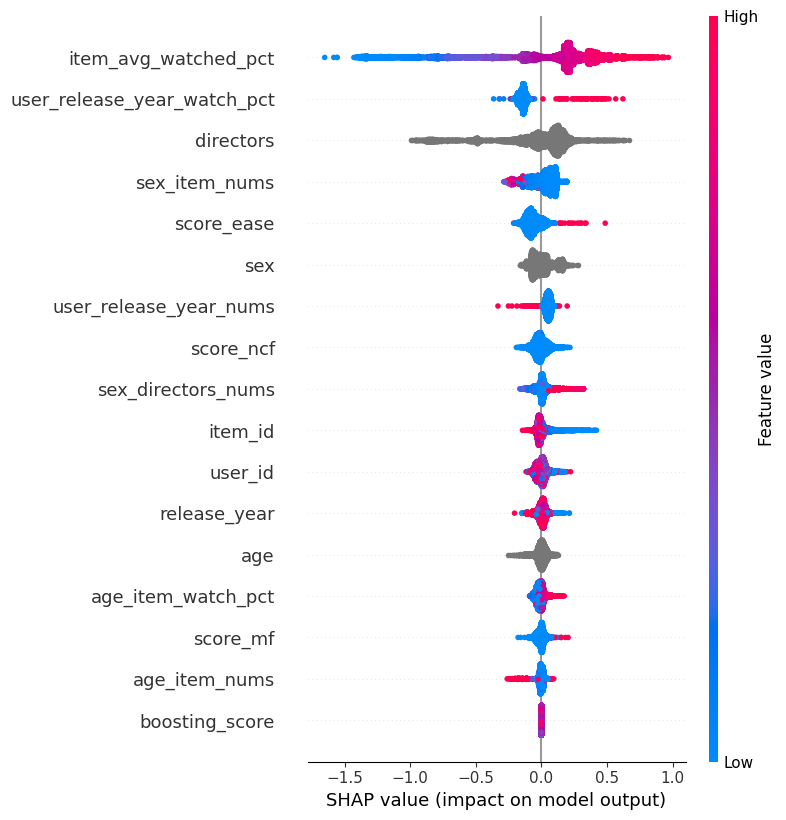

In [ ]:
import shap

explainer = shap.TreeExplainer(model_classifier)
shap_values = explainer.shap_values(X_test[:10000])
shap.summary_plot(shap_values, X_test[:10000])


Заметим, что наибольший вклад в модель дает признак "средний процент просмотров данного фильма", что вполне логично, это сильный признак. Если юзеры часто смотрят этот фильм и смотрят его до конца, то его логично рекомендовать, раз он популярный


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [168]:
# так как обучаю в коллабе, а он вылетает при большом числе юзеров, то будем брать только 30000
n_users = 30000
data = pd.concat([df, test_df])
users = data.user_id.unique()
sample_users = np.random.choice(users, size=n_users, replace=False)

data = data[data.user_id.isin(sample_users)]

In [169]:
filtered_data, user2id, item2id, id2user, id2item = df_encode(data)
joined = create_frame(data, None)

<ipython-input-84-5c7d458a66d3>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(


In [170]:
matrix = create_matrix(filtered_data, user2id, item2id)
model_ease = EASE(user2id, item2id, id2user, id2item)
w = model_ease.fit_ease(matrix)
joined['ease_preds'] = joined.train_interactions.apply(lambda x: model_ease.get_preds_all(x, item2id, id2item, topn=40))


In [173]:
model_matrix = MatrixSVD(user2id, item2id, id2user, id2item)
mf_recommendations = model_matrix.make_svd_recommendations(coo_array(matrix), 10, 40)

In [174]:

joined['mf_predictions'] = joined.apply(lambda x: [id2item[i] for i in mf_recommendations[user2id[x['user_id']]]], axis=1)


In [175]:
users_encoder = LabelEncoder().fit(data.user_id.values)
items_encoder = LabelEncoder().fit(data.item_id.values)

train_encoded_users = torch.Tensor(users_encoder.transform(data.user_id.values)).long()
train_encoded_items = torch.Tensor(items_encoder.transform(data.item_id.values)).long()
dataset = NCFDataset(train_encoded_users, train_encoded_items)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
model_ncf = NCF(data, users_encoder, items_encoder, device=device).to(device)
train(model_ncf, dataloader, device)

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

In [176]:
recommendations = model_ncf.make_recommendations(users_encoder, items_encoder, train_encoded_users, train_encoded_items, device=device, topn=40, batch_size=data.item_id.nunique())

In [177]:
user_idx = users_encoder.transform(joined.user_id.values)
user_recommend = np.array(recommendations)[user_idx]
items_flattened = items_encoder.inverse_transform(user_recommend.flatten())
items_recommend = items_flattened.reshape(user_recommend.shape)
joined['ncf_predictions'] = items_recommend.tolist()


In [180]:
joined['item_id'] = joined.apply(lambda x: list(set(x['ease_preds'] + x['mf_predictions'] + x['ncf_predictions'])), axis=1)

In [181]:
test_data = joined.explode('item_id', ignore_index=True)
test_data = test_data.drop(columns=['train_interactions', 'ease_preds', 'mf_predictions', 'ncf_predictions'])

In [183]:
test_with_features = create_features_(from_df=data, to_df=test_data, df_users=df_users, df_items=df_items)

Используем нашу модель, чтобы получить скоры релевантности и отобрать лучших k кандидатов

In [184]:
X_test = add_scores(test_with_features, data, model_ease, model_matrix, model_ncf)

In [185]:
X_test['boosting_score'] = model_classifier.predict_proba(X_test)[:, 1]


In [235]:
def get_top_recommendations(X_test, topn=20):
  X_sorted = X_test.sort_values(by='boosting_score', ascending=False)
  recommendations = (
      X_sorted.groupby('user_id')['item_id'].apply(lambda x: x.head(topn).tolist()).reset_index()
      .rename(columns={'item_id': f'recommendations'})
  )
  return recommendations


In [236]:
rec = get_top_recommendations(X_test)
rec

,user_id,recommendations
0,115,"[13865, 14732, 14361, 3734, 13928, 884, 13025,..."
1,183,"[3734, 13865, 14732, 10586, 7458, 4260, 1844, ..."
2,247,"[13865, 13928, 3734, 14732, 15297, 15787, 4092..."
3,255,"[13865, 3734, 9728, 10482, 4631, 16476, 837, 8..."
4,265,"[10556, 3734, 12268, 16270, 10586, 13545, 1123..."
...,...,...
29995,1097344,"[3734, 13865, 8636, 11237, 15170, 14431, 15297..."
29996,1097353,"[15297, 8636, 9728, 142, 9169, 3432, 10440, 23..."
29997,1097399,"[13865, 3734, 3873, 905, 2323, 1287, 3660, 164..."
29998,1097496,"[11494, 7441, 8067, 834, 14313, 5675, 13653, 4..."


Анализ diversity(k)


In [239]:
def ranked_based_overlap(recom1, recom2):
  return rbo.RankingSimilarity(recom1, recom2).rbo()

def calculate_rbo(recommendations: Union[np.ndarray, pd.DataFrame], n=10000):
  result_rbo = 0
  users = np.random.choice(recommendations.shape[0], size=n, replace=False)
  for i in range(0, len(users), 2):

    if isinstance(recommendations, pd.DataFrame):
      result_rbo += ranked_based_overlap(recommendations.iloc[users[i]]['recommendations'], recommendations.iloc[users[i+1]]['recommendations'])
    else:
      result_rbo += ranked_based_overlap(recommendations[users[i]], recommendations[users[i+1]])
  return result_rbo / n


def analyse_diversity(X_test):
  metrics = []
  k_values = np.arange(10, 61, 10)
  for i in range(10, 61, 10):
    recommendations = get_top_recommendations(X_test, topn=i)
    metrics.append(calculate_rbo(recommendations))
  return np.array(metrics), k_values



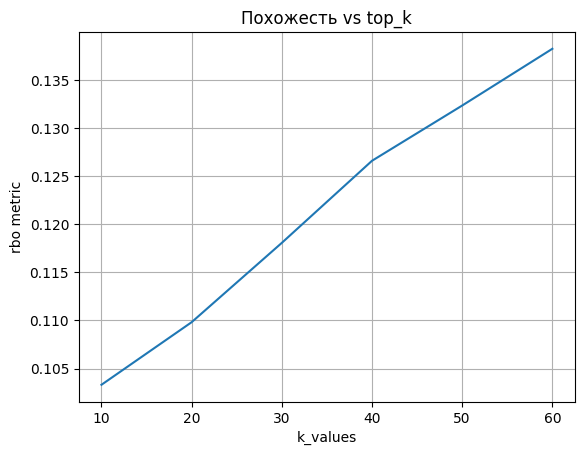

In [241]:
import matplotlib.pyplot as plt

metrics, k_values = analyse_diversity(X_test)

plt.plot(k_values, metrics)
plt.xlabel("k_values")
plt.ylabel("rbo metric")
plt.grid()
plt.title("Похожесть vs top_k")
plt.show()


Похожесть айтемов в списке рекомендаций увеличивается, если мы увеличиваем количество рекомендованных айтемов  